<a href="https://www.kaggle.com/code/hasninasri/tunesien-lecence-plate?scriptVersionId=131145938" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Introduction

This example demonstrates a simple OCR model built with the Functional API. Apart from
combining CNN and RNN, it also illustrates how you can instantiate a new layer
and use it as an "Endpoint layer" for implementing CTC loss. For a detailed
guide to layer subclassing, please check out
[this page](https://keras.io/guides/making_new_layers_and_models_via_subclassing/)
in the developer guides.

## Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load the data: 
Let's download the data.

The dataset contains 1040 captcha files as `png` images. The label for each sample is a string,
the name of the file (minus the file extension).
We will map each character in the string to an integer for training the model. Similary,
we will need to map the predictions of the model back to strings. For this purpose
we will maintain two dictionaries, mapping characters to integers, and integers to characters,
respectively.

In [2]:
import pandas as pd
plates_recognition = pd.read_csv('/kaggle/input/tun-lecence-plates/license_plates_recognition_train.csv')
display(plates_recognition.sample(), ' '.join(plates_recognition.iloc[0].text))

,img_id,text
118,205.jpg,93T4591


'1 1 7 T 3 9 8 9'

In [3]:
plates_recognition['size'] = plates_recognition['text'].apply(lambda x : len(x))
plates_recognition['size'].unique()

array([8, 7, 6, 5])

In [4]:
plates_recognition['text_before'] = plates_recognition['text'].apply(lambda x : ''.join([i if i.isnumeric() else '' for i in x[:3]])).apply(lambda x : '000'+x).apply(lambda x : x[-3:])
plates_recognition['text_last'] = plates_recognition['text'].apply(lambda x : ''.join([i if i.isnumeric() else '' for i in x[-4:]])).apply(lambda x : '0000'+x).apply(lambda x : x[-4:])

plates_recognition['text'] = plates_recognition['text_before']+'TN'+plates_recognition['text_last']

In [5]:
plates_recognition['text']

0      117TN3989
1      128TN8086
2      094TN3458
3      133TN6719
4      068TN5979
         ...    
895    039TN8707
896    092TN0589
897    180TN0706
898    087TN7369
899    159TN8894
Name: text, Length: 900, dtype: object

In [6]:

# Path to the data directory
data_dir = Path("/kaggle/input/tun-lecence-plates/license_plates_recognition_train/license_plates_recognition_train")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.jpg")))))
labels = plates_recognition['text']
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 128

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

Number of images found:  900
Number of labels found:  900
Number of unique characters:  12
Characters present:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'N', 'T']


In [7]:
test_dir = Path('/kaggle/input/tun-lecence-plates/test/test_private')
test_images = sorted(list(map(str, list(test_dir.glob("*.jpg")))))

## Preprocessing

In [8]:
# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label, "path":img_path}

## Create `Dataset` objects

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [10]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, ['000TN0000' for x in np.arange(len(test_images))]))
test_dataset = (
    test_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(1)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

## Visualize the data

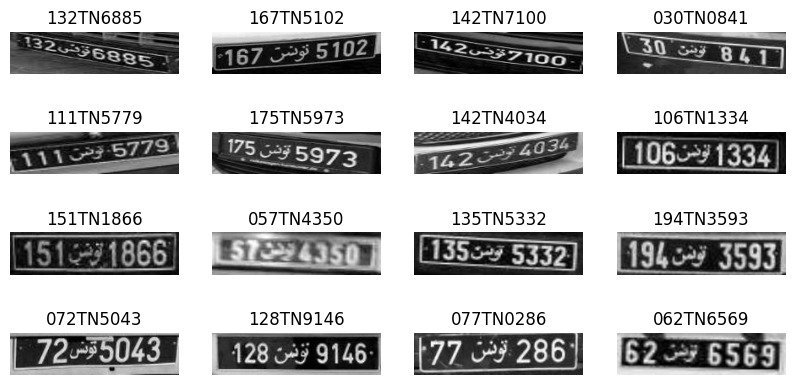

In [11]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

## Model

In [12]:

class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")
    
#     input_img = layers.Resizing(img_width, img_height)(input_img)
    
    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        use_bias=True,
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        use_bias=True,
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.35)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.35))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.35))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

## Training

In [13]:
epochs = 350
early_stopping_patience = 15
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)


Epoch 1/350


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['path'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


7/7 [==============================] - 16s 1s/step - loss: 41.6885 - val_loss: 30.3875
Epoch 2/350
7/7 [==============================] - 7s 980ms/step - loss: 25.8061 - val_loss: 25.2135
Epoch 3/350
7/7 [==============================] - 7s 944ms/step - loss: 24.7177 - val_loss: 24.3253
Epoch 4/350
7/7 [==============================] - 7s 943ms/step - loss: 24.1702 - val_loss: 23.9129
Epoch 5/350
7/7 [==============================] - 7s 929ms/step - loss: 23.7208 - val_loss: 23.4988
Epoch 6/350
7/7 [==============================] - 7s 923ms/step - loss: 23.5618 - val_loss: 23.4335
Epoch 7/350
7/7 [==============================] - 7s 967ms/step - loss: 23.3645 - val_loss: 23.2240
Epoch 8/350
7/7 [==============================] - 7s 981ms/step - loss: 23.1512 - val_loss: 22.9544
Epoch 9/350
7/7 [==============================] - 8s 1s/step - loss: 22.9491 - val_loss: 22.8877
Epoch 10/350
7/7 [==============================] - 7s 1s/step - loss: 22.7416 - val_loss: 22.6088
Epoch 11/

## Inference

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/ocr-for-captcha) 
and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/ocr-for-captcha).

In [ ]:
# # convert.py

# import glob
# import os
# import pickle
# import xml.etree.ElementTree as ET
# from os import listdir, getcwd
# from os.path import join


# def get_images_in_dir(dir_path):
#     image_list = []
#     for filename in glob.glob(dir_path + '/*.jpg'):
#         image_list.append(filename)

#     return image_list


# def convert(size, box):
#     dw = 1./(size[0])
#     dh = 1./(size[1])
#     x = (box[0] + box[1])/2.0 - 1
#     y = (box[2] + box[3])/2.0 - 1
#     w = box[1] - box[0]
#     h = box[3] - box[2]
#     x = x*dw
#     w = w*dw
#     y = y*dh
#     h = h*dh
#     return (x,y,w,h)


# def convert_annotation(dir_path, output_path, image_path):
#     basename = os.path.basename(image_path)
#     basename_no_ext = os.path.splitext(basename)[0]

#     in_file = open(dir_path + '/' + basename_no_ext + '.xml')
#     out_file = open(output_path + basename_no_ext + '.txt', 'w')
#     tree = ET.parse(in_file)
#     root = tree.getroot()
#     size = root.find('size')
#     w = int(size.find('width').text)
#     h = int(size.find('height').text)

#     for obj in root.iter('object'):
#         difficult = obj.find('difficult').text
#         cls = obj.find('name').text
#         if cls not in classes or int(difficult)==1:
#             continue
#         cls_id = classes.index(cls)
#         xmlbox = obj.find('bndbox')
#         b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
#         bb = convert((w,h), b)
#         out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')


# cwd = getcwd()
# dirs = ['train','test']
# classes = ['LP']

# for dir_path in dirs:
#     full_dir_path = cwd + '/' + dir_path
#     output_path = full_dir_path +'/../labels/'

#     if not os.path.exists(output_path):
#         os.makedirs(output_path)

#     image_paths = get_images_in_dir(full_dir_path)
#     list_file = open(full_dir_path + '.txt', 'w')

#     for image_path in image_paths:
#         list_file.write(image_path + '\n')
#         convert_annotation(full_dir_path, output_path, image_path)
#     list_file.close()

#     print("Finished processing: " + dir_path)

In [14]:
# # This code is written at BigVision LLC. It is based on the OpenCV project. It is subject to the license terms in the LICENSE file found in this distribution and at http://opencv.org/license.html

# import cv2 as cv
# import argparse
# import sys
# import numpy as np
# import os.path

# # Initialize the parameters
# confThreshold = 0.5  # Confidence threshold
# nmsThreshold = 0.4  # Non-maximum suppression threshold

# inpWidth = 416  # 608     # Width of network's input image
# inpHeight = 416  # 608     # Height of network's input image

# parser = argparse.ArgumentParser(
#     description='Object Detection using YOLO in OPENCV')
# parser.add_argument('--image', help='Path to image file.')
# parser.add_argument('--video', help='Path to video file.')
# args = parser.parse_args()

# # Load names of classes
# classesFile = "classes.names"

# classes = None
# with open(classesFile, 'rt') as f:
#     classes = f.read().rstrip('\n').split('\n')

# # Give the configuration and weight files for the model and load the network using them.

# modelConfiguration = "darknet-yolov3.cfg"
# modelWeights = "model.weights"

# net = cv.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
# net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
# net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

# # Get the names of the output layers


# def getOutputsNames(net):
#     # Get the names of all the layers in the network
#     layersNames = net.getLayerNames()
#     # Get the names of the output layers, i.e. the layers with unconnected outputs
#     return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# # Draw the predicted bounding box


# def drawPred(classId, conf, left, top, right, bottom):
#     # Draw a bounding box.
#     #    cv.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
#     cv.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 3)

#     label = '%.2f' % conf

#     # Get the label for the class name and its confidence
#     if classes:
#         assert(classId < len(classes))
#         label = '%s: %s' % (classes[classId], label)

#     # Display the label at the top of the bounding box
#     labelSize, baseLine = cv.getTextSize(
#         label, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)
#     top = max(top, labelSize[1])
#     cv.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(
#         1.5*labelSize[0]), top + baseLine), (255, 0, 255), cv.FILLED)
#     #cv.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine),    (255, 255, 255), cv.FILLED)
#     cv.putText(frame, label, (left, top),
#                cv.FONT_HERSHEY_SIMPLEX, 0.70, (255, 255, 255), 2)

# # Remove the bounding boxes with low confidence using non-maxima suppression


# def postprocess(frame, outs):
#     frameHeight = frame.shape[0]
#     frameWidth = frame.shape[1]

#     classIds = []
#     confidences = []
#     boxes = []
#     # Scan through all the bounding boxes output from the network and keep only the
#     # ones with high confidence scores. Assign the box's class label as the class with the highest score.
#     classIds = []
#     confidences = []
#     boxes = []
#     for out in outs:
#         print("out.shape : ", out.shape)
#         for detection in out:
#             # if detection[4]>0.001:
#             scores = detection[5:]
#             classId = np.argmax(scores)
#             # if scores[classId]>confThreshold:
#             confidence = scores[classId]
#             if detection[4] > confThreshold:
#                 print(detection[4], " - ", scores[classId],
#                       " - th : ", confThreshold)
#                 print(detection)
#             if confidence > confThreshold:
#                 center_x = int(detection[0] * frameWidth)
#                 center_y = int(detection[1] * frameHeight)
#                 width = int(detection[2] * frameWidth)
#                 height = int(detection[3] * frameHeight)
#                 left = int(center_x - width / 2)
#                 top = int(center_y - height / 2)
#                 classIds.append(classId)
#                 confidences.append(float(confidence))
#                 boxes.append([left, top, width, height])

#     # Perform non maximum suppression to eliminate redundant overlapping boxes with
#     # lower confidences.
#     indices = cv.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
#     for i in indices:
#         i = i[0]
#         box = boxes[i]
#         left = box[0]
#         top = box[1]
#         width = box[2]
#         height = box[3]
#         drawPred(classIds[i], confidences[i], left,
#                  top, left + width, top + height)


# # Process inputs
# winName = 'Deep learning object detection in OpenCV'
# cv.namedWindow(winName, cv.WINDOW_NORMAL)

# outputFile = "yolo_out_py.avi"
# if (args.image):
#     # Open the image file
#     if not os.path.isfile(args.image):
#         print("Input image file ", args.image, " doesn't exist")
#         sys.exit(1)
#     cap = cv.VideoCapture(args.image)
#     outputFile = args.image[:-4]+'_yolo_out_py.jpg'
# elif (args.video):
#     # Open the video file
#     if not os.path.isfile(args.video):
#         print("Input video file ", args.video, " doesn't exist")
#         sys.exit(1)
#     cap = cv.VideoCapture(args.video)
#     outputFile = args.video[:-4]+'_yolo_out_py.avi'
# else:
#     # Webcam input
#     cap = cv.VideoCapture(0)

# # Get the video writer initialized to save the output video
# if (not args.image):
#     vid_writer = cv.VideoWriter(outputFile, cv.VideoWriter_fourcc('M', 'J', 'P', 'G'), 30, (round(
#         cap.get(cv.CAP_PROP_FRAME_WIDTH)), round(cap.get(cv.CAP_PROP_FRAME_HEIGHT))))

# while cv.waitKey(1) < 0:

#     # get frame from the video
#     hasFrame, frame = cap.read()

#     # Stop the program if reached end of video
#     if not hasFrame:
#         print("Done processing !!!")
#         print("Output file is stored as ", outputFile)
#         cv.waitKey(3000)
#         break

#     # Create a 4D blob from a frame.
#     blob = cv.dnn.blobFromImage(
#         frame, 1/255, (inpWidth, inpHeight), [0, 0, 0], 1, crop=False)

#     # Sets the input to the network
#     net.setInput(blob)

#     # Runs the forward pass to get output of the output layers
#     outs = net.forward(getOutputsNames(net))

#     # Remove the bounding boxes with low confidence
#     postprocess(frame, outs)

#     # Put efficiency information. The function getPerfProfile returns the overall time for inference(t) and the timings for each of the layers(in layersTimes)
#     t, _ = net.getPerfProfile()
#     label = 'Inference time: %.2f ms' % (t * 1000.0 / cv.getTickFrequency())
#     #cv.putText(frame, label, (0, 15), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

#     # Write the frame with the detection boxes
#     if (args.image):
#         cv.imwrite(outputFile, frame.astype(np.uint8))
#     else:
#         vid_writer.write(frame.astype(np.uint8))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

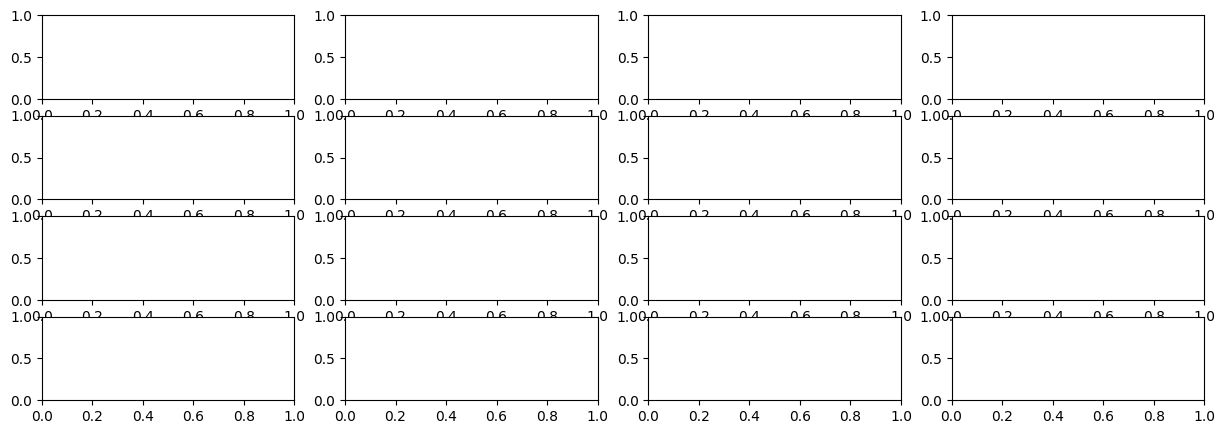

In [15]:

# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
#         ax[i // 4, i % 4].imshow(img, cmap="gray")
#         ax[i // 4, i % 4].set_title(title)
#         ax[i // 4, i % 4].axis("off")
plt.show()

In [16]:
list_paths = []
pred_texts = []
i = 0
for batch in test_dataset:
    batch_images = batch["image"]
    list_paths.append(batch["path"])
    i+=1
    preds = prediction_model.predict(batch_images)
    pred_texts.append(decode_batch_predictions(preds))

1/1 [==============================] - 0s 26ms/step


In [17]:
pred_texts

[['162TN297[UNK]'],
 ['090TN54[UNK][UNK]'],
 ['11TN[UNK][UNK][UNK][UNK][UNK]'],
 ['161TN19[UNK][UNK]'],
 ['106TN3[UNK][UNK][UNK]'],
 ['17TN0647[UNK]'],
 ['064TN05[UNK][UNK]'],
 ['080TN85[UNK][UNK]'],
 ['13TN089[UNK][UNK]'],
 ['163TN107[UNK]'],
 ['121TN09[UNK][UNK]'],
 ['10TN74[UNK][UNK][UNK]'],
 ['073TN09[UNK][UNK]'],
 ['121TN67[UNK][UNK]'],
 ['136TN89[UNK][UNK]'],
 ['167TN09[UNK][UNK]'],
 ['13TN09[UNK][UNK][UNK]'],
 ['163TN5[UNK][UNK][UNK]'],
 ['090TN2[UNK][UNK][UNK]'],
 ['17TN127[UNK][UNK]'],
 ['130TN37[UNK][UNK]'],
 ['068TN8[UNK][UNK][UNK]'],
 ['063TN79[UNK][UNK]'],
 ['093TN05[UNK][UNK]'],
 ['095TN8541'],
 ['140TN818[UNK]'],
 ['12TN847[UNK][UNK]'],
 ['06TN14[UNK][UNK][UNK]'],
 ['17TN39[UNK][UNK][UNK]'],
 ['094TN739[UNK]'],
 ['183TN059[UNK]'],
 ['127TN084[UNK]'],
 ['155TN058[UNK]'],
 ['11TN9[UNK][UNK][UNK][UNK]'],
 ['091TN159[UNK]'],
 ['12TN[UNK][UNK][UNK][UNK][UNK]'],
 ['13TN05[UNK][UNK][UNK]'],
 ['12TN79[UNK][UNK][UNK]'],
 ['09TN0[UNK][UNK][UNK][UNK]'],
 ['095TN78[UNK][UNK]'],
 ['0

In [18]:
predictions_df  = pd.DataFrame(columns=['id','preds'])
predictions_df['id'] = [str(list_paths[i].numpy()[0]).split('/')[-1].split('.')[0] for i in np.arange(len(list_paths))]
predictions_df['preds'] = [[i.replace('[UNK]','') for i in strg][0] for strg in pred_texts]
predictions_df['id'] = predictions_df['id'].apply(lambda x: 'img_'+str(x))
predictions_df

,id,preds
0,img_1000,162TN297
1,img_1001,090TN54
2,img_1002,11TN
3,img_1003,161TN19
4,img_1004,106TN3
...,...,...
205,img_995,094TN479
206,img_996,083TN590
207,img_997,136TN878
208,img_998,11TN9


In [19]:
predictions_df['preds_text_before'] = predictions_df.preds.apply(lambda x: x.split('TN')[0]).apply(lambda x : '000'+x).apply(lambda x : x[-3:])
predictions_df['preds_text_last'] = predictions_df.preds.apply(lambda x: x.split('TN')[1]).apply(lambda x : '0000'+x).apply(lambda x : x[-4:])
predictions_df['text'] = predictions_df['preds_text_before']+predictions_df['preds_text_last']
final_predictions = pd.DataFrame(columns=['id','number'])

In [20]:
for i in np.arange(len(predictions_df['text'][0])):
    aux = pd.DataFrame(columns=['id','number'])
    aux['number'] = predictions_df['text'].apply(lambda x: x[i])
    aux['id'] = predictions_df['id'].apply(lambda x: x+'_'+str(i+1))
    final_predictions = pd.concat([final_predictions, aux])
final_predictions = final_predictions.reset_index(drop=True)

In [21]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
one_hot = enc.fit_transform(np.array(final_predictions['number']).reshape(-1, 1)).toarray()
one_hot = pd.DataFrame(one_hot).astype(int)
one_hot['id'] = final_predictions['id']
one_hot = one_hot[['id', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
one_hot.to_csv('submission.csv', index=False)

In [22]:
one_hot

,id,0,1,2,3,4,5,6,7,8,9
0,img_1000_1,0,1,0,0,0,0,0,0,0,0
1,img_1001_1,1,0,0,0,0,0,0,0,0,0
2,img_1002_1,1,0,0,0,0,0,0,0,0,0
3,img_1003_1,0,1,0,0,0,0,0,0,0,0
4,img_1004_1,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1465,img_995_7,0,0,0,0,0,0,0,0,0,1
1466,img_996_7,1,0,0,0,0,0,0,0,0,0
1467,img_997_7,0,0,0,0,0,0,0,0,1,0
1468,img_998_7,0,0,0,0,0,0,0,0,0,1
